Calculating AUC just for single task ID.<br> Therefore, not making a scalable solution for POC.

In [166]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

In [168]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


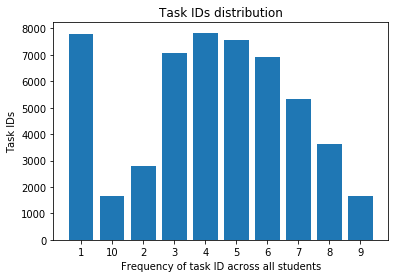

Task IDs mapping: 
Task ID -> p7cfRPp-kQ.partb(1) is attempted 7776 times.
Task ID -> Ok-iIHxjgx.partb(2) is attempted 2789 times.
Task ID -> 1zsCldT4p8.set1(3) is attempted 7061 times.
Task ID -> DebcfZEEmI.proper_fractions(4) is attempted 7836 times.
Task ID -> 9wRCzK1G7F.partb(5) is attempted 7552 times.
Task ID -> 1zsCldT4p8.set2(6) is attempted 6905 times.
Task ID -> nl-M69Ez9k.parta(7) is attempted 5335 times.
Task ID -> kvig7fcCVc.partb(8) is attempted 3621 times.
Task ID -> Ok-iIHxjgx.parta(9) is attempted 1670 times.
Task ID -> hyei4uD81i.parta(10) is attempted 1664 times.


In [177]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
position_2 = 1
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in another_2:
            another_2[j['task_id']] = str(position_2)
            position_2 = position_2 + 1
        cnt2[another_2[j['task_id']]] += 1
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times.")

In [220]:
test_AUC_all_tasks = {}
train_AUC_all_tasks = {}
for i in another_2:
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    train_AUC_taski = []
    test_AUC_taski = []
    #make sequences
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.,0.])
                else:
                    interactions.append([0.,1.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)

    #do the padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths),2])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_seqlen = sequences_lengths[split:]

    num_units = 5
    len_vector = 2
    l_rate = 0.1
    epochs = 100
    display_ep = 10
    
    for r in range(10):
        print("\n\n"+ str(r+1) + " Time Run.")
        # build the network
        tf.reset_default_graph()
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid)
            outputs = tf.nn.sigmoid(outputs)
            return outputs

        pred = dynamicRNN(x)
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
        #optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        optimizer = tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9).minimize(cost)
        auc,  opts = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')

        #execute the network
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            for epoch in range(1, epochs+1):
                sess.run(optimizer, feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                if epoch % display_ep == 0 or epoch == 1:
                    loss, trainAUC, trainOPTS = sess.run([cost,auc,opts], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                    testAUC, testOPTS = sess.run([auc,opts], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
                    print("Step: " + str(epoch) +", cost: "+str(loss)+ ", train set AUC: " + str(trainOPTS) +":"+str(trainAUC) + ", test set AUC: "+ str(testOPTS)+":"+str(testAUC) +";")
            prediction = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
            view_point = np.argmax(test_seqlen)
            print("\n\ntrue:\n")
            print(test_x[view_point][:test_seqlen[view_point]])
            print("\n\nprediction\n")
            print(prediction[0][view_point][:test_seqlen[view_point]])
            train_AUC_taski.append(trainOPTS)
            test_AUC_taski.append(testOPTS)
    test_AUC_all_tasks[i] = [np.mean(test_AUC_taski),np.std(test_AUC_taski)]
    train_AUC_all_tasks[i] = [np.mean(train_AUC_taski),np.std(train_AUC_taski)]




Calculating for Task ID: p7cfRPp-kQ.partb which has the frequency: 7776



1 Time Run.
Step: 1, cost: 1.0172265, train set AUC: 0.8729469:0.0, test set AUC: 0.8689061:0.8729469;
Step: 10, cost: 1.0147917, train set AUC: 0.8603636:0.8689061, test set AUC: 0.85723984:0.8603636;
Step: 20, cost: 1.0099351, train set AUC: 0.8230883:0.85723984, test set AUC: 0.8190558:0.8230883;
Step: 30, cost: 1.0043458, train set AUC: 0.75210947:0.8190558, test set AUC: 0.7449219:0.75210947;
Step: 40, cost: 0.9986395, train set AUC: 0.69771504:0.7449219, test set AUC: 0.6922943:0.69771504;
Step: 50, cost: 0.9932431, train set AUC: 0.65783525:0.6922943, test set AUC: 0.65396965:0.65783525;
Step: 60, cost: 0.988296, train set AUC: 0.63194954:0.65396965, test set AUC: 0.62981397:0.63194954;
Step: 70, cost: 0.98393404, train set AUC: 0.61742115:0.62981397, test set AUC: 0.61658144:0.61742115;
Step: 80, cost: 0.980066, train set AUC: 0.6052965:0.61658144, test set AUC: 0.6044492:0.6052965;
Step: 90, cost: 0.

Step: 10, cost: 1.0150309, train set AUC: 0.76656044:0.80830365, test set AUC: 0.7618164:0.76656044;
Step: 20, cost: 1.0101012, train set AUC: 0.66883624:0.7618164, test set AUC: 0.6627316:0.66883624;
Step: 30, cost: 1.0045081, train set AUC: 0.61603194:0.6627316, test set AUC: 0.61351776:0.61603194;
Step: 40, cost: 0.998796, train set AUC: 0.58822984:0.61351776, test set AUC: 0.5865394:0.58822984;
Step: 50, cost: 0.99339277, train set AUC: 0.5717433:0.5865394, test set AUC: 0.5716722:0.5717433;
Step: 60, cost: 0.98843193, train set AUC: 0.5621984:0.5716722, test set AUC: 0.56267744:0.5621984;
Step: 70, cost: 0.9840363, train set AUC: 0.55730253:0.56267744, test set AUC: 0.5578969:0.55730253;
Step: 80, cost: 0.98006994, train set AUC: 0.55161345:0.5578969, test set AUC: 0.5515256:0.55161345;
Step: 90, cost: 0.97668153, train set AUC: 0.5494012:0.5515256, test set AUC: 0.55030537:0.5494012;
Step: 100, cost: 0.97390074, train set AUC: 0.54913765:0.55030537, test set AUC: 0.5500444:0.5491

Step: 30, cost: 1.0039307, train set AUC: 0.7171439:0.77797323, test set AUC: 0.71174836:0.7171439;
Step: 40, cost: 0.99824274, train set AUC: 0.67489827:0.71174836, test set AUC: 0.6711553:0.67489827;
Step: 50, cost: 0.99287474, train set AUC: 0.64899784:0.6711553, test set AUC: 0.64738804:0.64899784;
Step: 60, cost: 0.9879576, train set AUC: 0.6329397:0.64738804, test set AUC: 0.6321988:0.6329397;
Step: 70, cost: 0.9836255, train set AUC: 0.6232824:0.6321988, test set AUC: 0.62313545:0.6232824;
Step: 80, cost: 0.9798038, train set AUC: 0.6167444:0.62313545, test set AUC: 0.6167924:0.6167444;
Step: 90, cost: 0.97642964, train set AUC: 0.6110374:0.6167924, test set AUC: 0.6110195:0.6110374;
Step: 100, cost: 0.97368234, train set AUC: 0.60684514:0.6110195, test set AUC: 0.6070156:0.60684514;


true:

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]


Step: 80, cost: 0.94987035, train set AUC: 0.44653463:0.43792853, test set AUC: 0.44821602:0.44653463;
Step: 90, cost: 0.9468913, train set AUC: 0.45431107:0.44821602, test set AUC: 0.45549983:0.45431107;
Step: 100, cost: 0.94424856, train set AUC: 0.4600407:0.45549983, test set AUC: 0.4609477:0.4600407;


true:

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


prediction

[[0.55410767 0.5494785 ]
 [0.5512873  0.54931146]
 [0.5487285  0.54926693]
 [0.54656774 0.5492616 ]
 [0.54480714 0.5492639 ]
 [0.5433951  0.54926544]
 [0.5422679  0.54926574]
 [0.5413669  0.5492661 ]
 [0.540643   0.5492673 ]
 [0.54005754 0.5492695 ]
 [0.5395806  0.54927254]
 [0.53918916 0.5492762 ]
 [0.5388659  0.54927987]
 [0.5385976  0.5492835 ]
 [0.5383738  0.54928684]
 [0.53818667 0.5492898 ]
 [0.53802973 0.5492924 ]
 [0.53789794 0.5492946 ]
 [0.53778726 0.5492963 ]
 [0.53

Step: 1, cost: 0.9805835, train set AUC: 0.7204541:0.0, test set AUC: 0.7285246:0.7204541;
Step: 10, cost: 0.978511, train set AUC: 0.659375:0.7285246, test set AUC: 0.65490663:0.659375;
Step: 20, cost: 0.9744845, train set AUC: 0.6106841:0.65490663, test set AUC: 0.60921293:0.6106841;
Step: 30, cost: 0.9698656, train set AUC: 0.58286035:0.60921293, test set AUC: 0.5805681:0.58286035;
Step: 40, cost: 0.965188, train set AUC: 0.56578755:0.5805681, test set AUC: 0.56453097:0.56578755;
Step: 50, cost: 0.96070665, train set AUC: 0.5526402:0.56453097, test set AUC: 0.5509108:0.5526402;
Step: 60, cost: 0.95658016, train set AUC: 0.54348624:0.5509108, test set AUC: 0.5426766:0.54348624;
Step: 70, cost: 0.95282686, train set AUC: 0.5376375:0.5426766, test set AUC: 0.53711104:0.5376375;
Step: 80, cost: 0.9494801, train set AUC: 0.5343405:0.53711104, test set AUC: 0.5343238:0.5343405;
Step: 90, cost: 0.946519, train set AUC: 0.53291464:0.5343238, test set AUC: 0.5330404:0.53291464;
Step: 100, co

Step: 20, cost: 1.0036435, train set AUC: 0.71219957:0.8296846, test set AUC: 0.6999935:0.71219957;
Step: 30, cost: 0.9981749, train set AUC: 0.64956516:0.6999935, test set AUC: 0.6433644:0.64956516;
Step: 40, cost: 0.99261564, train set AUC: 0.6170328:0.6433644, test set AUC: 0.6130247:0.6170328;
Step: 50, cost: 0.9874574, train set AUC: 0.59451157:0.6130247, test set AUC: 0.5916424:0.59451157;
Step: 60, cost: 0.9826667, train set AUC: 0.58296233:0.5916424, test set AUC: 0.58157754:0.58296233;
Step: 70, cost: 0.9784311, train set AUC: 0.57625717:0.58157754, test set AUC: 0.5753025:0.57625717;
Step: 80, cost: 0.9745961, train set AUC: 0.5708566:0.5753025, test set AUC: 0.5698765:0.5708566;
Step: 90, cost: 0.9714214, train set AUC: 0.5653555:0.5698765, test set AUC: 0.5642152:0.5653555;
Step: 100, cost: 0.96846896, train set AUC: 0.5614493:0.5642152, test set AUC: 0.5606564:0.5614493;


true:

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0.

Step: 1, cost: 1.0113798, train set AUC: 0.5105798:0.0, test set AUC: 0.5088512:0.5105798;
Step: 10, cost: 1.0089976, train set AUC: 0.46909264:0.5088512, test set AUC: 0.46494114:0.46909264;
Step: 20, cost: 1.0041721, train set AUC: 0.4383242:0.46494114, test set AUC: 0.43205532:0.4383242;
Step: 30, cost: 0.9985782, train set AUC: 0.43700534:0.43205532, test set AUC: 0.43537843:0.43700534;
Step: 40, cost: 0.9928956, train set AUC: 0.44128513:0.43537843, test set AUC: 0.44081438:0.44128513;
Step: 50, cost: 0.9876271, train set AUC: 0.44780457:0.44081438, test set AUC: 0.44788623:0.44780457;
Step: 60, cost: 0.98274267, train set AUC: 0.45446065:0.44788623, test set AUC: 0.45478332:0.45446065;
Step: 70, cost: 0.9784529, train set AUC: 0.45819962:0.45478332, test set AUC: 0.4579151:0.45819962;
Step: 80, cost: 0.97458047, train set AUC: 0.4595475:0.4579151, test set AUC: 0.45900676:0.4595475;
Step: 90, cost: 0.971373, train set AUC: 0.46001273:0.45900676, test set AUC: 0.45946908:0.4600127

Step: 100, cost: 0.9688111, train set AUC: 0.5100585:0.51137924, test set AUC: 0.50928944:0.5100585;


true:

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.5514548  0.5472167 ]
 [0.551812   0.5479113 ]
 [0.55037844 0.5485582 ]
 [0.55064416 0.5490727 ]
 [0.549521   0.5492859 ]
 [0.5497881  0.5496854 ]
 [0.5489176  0.549685  ]
 [0.5484082  0.55013317]
 [0.5482666  0.55048853]
 [0.54923666 0.5507587 ]
 [0.5487584  0.5503608 ]
 [0.5484492  0.55063975]
 [0.5484107  0.5508699 ]
 [0.5495081  0.55112404]
 [0.5489743  0.5505891 ]
 [0.5495736  0.5508305 ]
 [0.5496192  0.55042374]
 [0.54924774 0.5501532 ]
 [0.54877037 0.549988  ]
 [0.5483198  0.5498949 ]
 [0.5475562  0.5498701 ]
 [0.5475

KeyboardInterrupt: 

In [209]:
pp.pprint(test_AUC_all_tasks)
pp.pprint(train_AUC_all_tasks)

{'1zsCldT4p8.set1': [0.53794026, 0.00097266294],
 '1zsCldT4p8.set2': [0.5463648, 0.0017357237],
 '9wRCzK1G7F.partb': [0.5366205, 0.0012712833],
 'DebcfZEEmI.proper_fractions': [0.5482954, 0.0042706993],
 'Ok-iIHxjgx.parta': [0.57228684, 0.01144236],
 'Ok-iIHxjgx.partb': [0.5255308, 0.005434483],
 'hyei4uD81i.parta': [0.4890855, 0.013791313],
 'kvig7fcCVc.partb': [0.5793609, 0.015127081],
 'nl-M69Ez9k.parta': [0.5464407, 0.0048880684],
 'p7cfRPp-kQ.partb': [0.546174, 0.0008474268]}
{'1zsCldT4p8.set1': [0.5368773, 0.00082156423],
 '1zsCldT4p8.set2': [0.5437304, 0.0016803223],
 '9wRCzK1G7F.partb': [0.530423, 0.0014787491],
 'DebcfZEEmI.proper_fractions': [0.545999, 0.0049521686],
 'Ok-iIHxjgx.parta': [0.566645, 0.0108796265],
 'Ok-iIHxjgx.partb': [0.5231419, 0.004775264],
 'hyei4uD81i.parta': [0.4891215, 0.012124698],
 'kvig7fcCVc.partb': [0.57128054, 0.014244122],
 'nl-M69Ez9k.parta': [0.5430025, 0.0058070677],
 'p7cfRPp-kQ.partb': [0.54173, 0.0007197173]}
